In [12]:
import torch
import torch.cuda
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests, tarfile
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cuda


In [14]:
dataPath = 'UTKFace'
if (dataPath not in os.listdir()):
    print("Downloading UTKFace...")
    url = "https://drive.google.com/uc?export=download&id=0BxYys69jI14kYVM3aVhKS1VhRUk&confirm=t&uuid=f981ca1d-ba0f-40c9-a4a0-8eaa887f3b6d&at=ANzk5s7e36SgjT0FlqBbRiijefRg:1681897584880"

    response = requests.get(url, stream=True)
    file = tarfile.open(fileobj=response.raw, mode="r|gz")
    file.extractall(path=".")
    print("Download complete.")
else:
    print("UTKFace already downloaded.")

UTKFace already downloaded.


In [15]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataPath, transform=None):
        self.dataPath = dataPath
        self.transform = transform
        #self.imagePaths = [f for f in os.listdir(self.dataPath) if f.endswith('.jpg')]
        self.imagePaths = [f for f in os.listdir(self.dataPath) if f.endswith('.jpg') and f.split('_')[2] != '4']
        
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]
        try:
            imageTensor = torchvision.io.read_image(f'{self.dataPath}/{imagePath}').float()
            fileName = imagePath.split('_')
            label = torch.Tensor([int(fileName[0]), int(fileName[1]), int(fileName[2])])
            if self.transform:
                imageTensor = self.transform(imageTensor)
            return imageTensor, label
        except:
            return self.__getitem__((index + 1) % len(self.imagePaths))
        
    def __len__(self):
        return len(self.imagePaths)

In [16]:
# Resize and normalizde
transform = transforms.Compose(
    [transforms.Resize(224, antialias=True),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = MyDataset(dataPath, transform=transform)

batchSize = 100
testSplit = 0.1 # use 10% of dataset as test
validSplit = 0.2 / (1-testSplit) # use 20% of dataset as validation

testSize = int(np.floor(len(dataset)*testSplit))
trainValidSize = len(dataset) - testSize
validSize = int(np.ceil(trainValidSize*validSplit))
trainSize = trainValidSize - validSize
print(len(dataset), trainSize, validSize, testSize)

trainValidSet, testSet = torch.utils.data.random_split(dataset, [trainValidSize, testSize])
trainSet, validSet = torch.utils.data.random_split(trainValidSet, [trainSize, validSize])

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False)

22016 15411 4404 2201


In [17]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel,self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad=False
        self.resnet.fc = nn.Linear(512, 512)
        self.ageHidden1 = nn.Linear(512,512)
        self.ageHidden2 = nn.Linear(512,256)
        self.ageDrop = nn.Dropout(p = 0.9)
        self.ageFc = nn.Linear(512,1)
        self.genderHidden = nn.Linear(512,512)
        self.genderFc = nn.Linear(512,2)
        self.ethnicityHidden = nn.Linear(512,512)
        #self.ethnicityFc = nn.Linear(512,5)
        self.ethnicityFc = nn.Linear(512,4)
    
    def forward(self, x):
        resOut = F.relu(self.resnet.forward(x))
        ageX = F.relu(self.ageHidden1(resOut))
        ageOut = self.ageFc(self.ageDrop(ageX))
        genderX = F.relu(self.genderHidden(resOut))
        genderOut = F.sigmoid(self.genderFc(resOut))
        ethnicityX = F.relu(self.ethnicityHidden(resOut))
        ethnicityOut = self.ethnicityFc(resOut)
        return ageOut, genderOut, ethnicityOut

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad=True

In [18]:
# ResNetModel()

In [19]:
def lossAge(predictAge, targetAge):
    # loss = torch.sqrt(F.mse_loss(predictAge, targetAge))
    # return loss

    # age ranges weights
    # age_ranges = [(0, 1), (2, 23), (24, 25), (26, 26), (27, 35), (36, 150)]
    # age_weights = [0.4, 1, 0.6, 0.2, 0.6, 1.5]

    age_ranges = [(0, 15), (16, 30), (31, 45), (46, 60), (61, 150)]
    age_weights = [1, 0.5, 0.7, 1, 2]

    # weighted age loss
    loss_weights = torch.zeros_like(targetAge, dtype=torch.float32)
    for i, (start, end) in enumerate(age_ranges):
        mask = (targetAge >= start) & (targetAge <= end)
        loss_weights[mask] = age_weights[i]
    loss = torch.sqrt(F.mse_loss(predictAge, targetAge, reduction='none'))
    weighted_loss = loss * loss_weights
    return torch.mean(weighted_loss)

def lossGender(predictGender, targetGender):
    # classWeights = torch.tensor([0.95, 1.06], dtype=torch.float32).to(device)
    classWeights = torch.tensor([1, 1], dtype=torch.float32).to(device)
    loss = F.binary_cross_entropy(predictGender, targetGender, weight=classWeights)
    return loss

def lossEthnicity(predictEthnicity, targetEthnicity):
    #classWeights = torch.tensor([0.5, 1, 1, 1, 2], dtype=torch.float32).to(device)
    #classWeights = torch.tensor([0.55, 1.60, 1.21, 1.38], dtype=torch.float32).to(device)
    classWeights = torch.tensor([0.55, 1.60, 1.21, 1.38], dtype=torch.float32).to(device)
    loss = F.cross_entropy(predictEthnicity, targetEthnicity, weight=classWeights)

    return loss

def lossFunction(predictAge, predictGender, predictEthnicity, targetAge, targetGender, targetEthnicity):
    alpha = 1/5 # weight for age prediction
    beta = 1 # weight for gender prediction
    gamma = 1 # weight for ethncity prediction
    ageLoss = lossAge(predictAge, targetAge)
    genderLoss = lossGender(predictGender, targetGender)
    ethnicityLoss = lossEthnicity(predictEthnicity, targetEthnicity)
    totalLoss = alpha * ageLoss + beta * genderLoss + gamma * ethnicityLoss
    return totalLoss, ageLoss, genderLoss, ethnicityLoss

In [20]:
def trainNetwork(model, optimizer, lossFunction, trainLoader, validLoader, epochs, unfreezeEpoch, device, modelPath):
    model.train()
    trainLoaderSize = len(trainLoader)
    validLoaderSize = len(validLoader)
    trainAgeLoss, trainGenderLoss, trainEthnicityLoss, trainTotalLoss = [], [], [], []
    validAgeLoss, validGenderLoss, validEthnicityLoss, validTotalLoss = [], [], [], []
    trainAge3Accuracy, trainAge5Accuracy, trainGenderAccuracy, trainEthnicityAccuracy = [], [], [], []
    validAge3Accuracy, validAge5Accuracy, validGenderAccuracy, validEthnicityAccuracy = [], [], [], []

    for epoch in tqdm(range(1, epochs + 1)):
        if epoch == unfreezeEpoch:
            model.unfreeze()
            print("\tUnfreeze the model for fine tuning")
        
        ### TRAINING ###
        trainAgeLoss.append(0)
        trainGenderLoss.append(0)
        trainEthnicityLoss.append(0)
        trainTotalLoss.append(0)
        trainAge3Accuracy.append(0)
        trainAge5Accuracy.append(0)
        trainGenderAccuracy.append(0)
        trainEthnicityAccuracy.append(0)

        for batch_nr, (images, labels) in enumerate(trainLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.long().to(device) 

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            #ethnicityLabels = F.one_hot(labels[:, 2], num_classes=5).float()
            ethnicityLabels = labels[:, 2]

            # Predict
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            # Get loss and backpropogate
            totalLoss, ageLoss, genderLoss, ethnicityLoss = lossFunction(agePredictions, genderPredictions, ethnicityPredictions, 
                                                            ageLabels.view(-1, 1).float(), F.one_hot(genderLabels, num_classes=2).float(), F.one_hot(ethnicityLabels, num_classes=4).float())
            
            totalLoss.backward()

            # Optimize parameters (weights and biases) and remove gradients after
            optimizer.step() 
            optimizer.zero_grad()

            # Save loss for whole epoch
            trainAgeLoss[-1] += ageLoss.item() / trainLoaderSize
            trainGenderLoss[-1] += genderLoss.item() / trainLoaderSize
            trainEthnicityLoss[-1] += ethnicityLoss.item() / trainLoaderSize
            trainTotalLoss[-1] += totalLoss.item() / trainLoaderSize

            # Calcualte accuracy
            totalTrain = len(images) * trainLoaderSize
            
            agePredictions = torch.round(agePredictions).view(1, -1)
            trainAge3Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 3).sum().item() * 100 / totalTrain
            trainAge5Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 5).sum().item() * 100 / totalTrain

            _, genderPredictions = torch.max(genderPredictions, 1) 
            trainGenderAccuracy[-1] += (genderPredictions == genderLabels).sum().item() * 100 / totalTrain

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            trainEthnicityAccuracy[-1] += (ethnicityPredictions == ethnicityLabels).sum().item() * 100 / totalTrain

        ### VALIDATION ###
        validAgeLoss.append(0)
        validGenderLoss.append(0)
        validEthnicityLoss.append(0)
        validTotalLoss.append(0)
        validAge3Accuracy.append(0)
        validAge5Accuracy.append(0)
        validGenderAccuracy.append(0)
        validEthnicityAccuracy.append(0)

        for batch_nr, (images, labels) in enumerate(validLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.long().to(device) 

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            #ethnicityLabels = F.one_hot(labels[:, 2], num_classes=5).float()
            ethnicityLabels = labels[:, 2]

            # Predict            
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            # Get loss
            totalLoss, ageLoss, genderLoss, ethnicityLoss = lossFunction(agePredictions, genderPredictions, ethnicityPredictions, 
                                                            ageLabels.view(-1, 1).float(), F.one_hot(genderLabels, num_classes=2).float(), F.one_hot(ethnicityLabels, num_classes=4).float())
            
            # Save loss for whole epoch
            validAgeLoss[-1] += ageLoss.item() / validLoaderSize
            validGenderLoss[-1] += genderLoss.item() / validLoaderSize
            validEthnicityLoss[-1] += ethnicityLoss.item() / validLoaderSize
            validTotalLoss[-1] += totalLoss.item() / validLoaderSize

            # Calcualte accuracy
            totalValid = len(images) * validLoaderSize

            agePredictions = torch.round(agePredictions).view(1, -1)
            validAge3Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 3).sum().item() * 100 / totalValid
            validAge5Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 5).sum().item() * 100 / totalValid
            
            _, genderPredictions = torch.max(genderPredictions, 1) 
            validGenderAccuracy[-1] += (genderPredictions == genderLabels).sum().item() * 100 / totalValid

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            validEthnicityAccuracy[-1] += (ethnicityPredictions == ethnicityLabels).sum().item() * 100 / totalValid


        # Print reuslt of epoch
        print(f'\n\tTraining Losses:     (Age: {trainAgeLoss[-1]:.3f}, Gender: {trainGenderLoss[-1]:.3f}, Ethnicity: {trainEthnicityLoss[-1]:.3f}, Total: {trainTotalLoss[-1]:.3f})\t'
              f'\n\tValidation Losses:   (Age: {validAgeLoss[-1]:.3f}, Gender: {validGenderLoss[-1]:.3f}, Ethnicity: {validEthnicityLoss[-1]:.3f}, Total: {validTotalLoss[-1]:.3f})\t'
              f'\n\tTraining Accuracy:   (Age+/-3: {trainAge3Accuracy[-1]:.2f}%, Age+/-5: {trainAge5Accuracy[-1]:.2f}%, Gender: {trainGenderAccuracy[-1]:.2f}%, Ethnicity: {trainEthnicityAccuracy[-1]:.2f}%)\t'
              f'\n\tValidation Accuracy: (Age+/-3: {validAge3Accuracy[-1]:.2f}%, Age+/-5: {validAge5Accuracy[-1]:.2f}%, Gender: {validGenderAccuracy[-1]:.2f}%, Ethnicity: {validEthnicityAccuracy[-1]:.2f}%)\t')
        
    torch.save(model, modelPath)
    print(f"Saved model to {modelPath}")
    losses = [trainAgeLoss, trainGenderLoss, trainEthnicityLoss, trainTotalLoss, validAgeLoss, validGenderLoss, validEthnicityLoss, validTotalLoss]
    accuracy = [trainAge3Accuracy, trainAge5Accuracy, trainGenderAccuracy, trainEthnicityAccuracy, validAge3Accuracy, validAge5Accuracy, validGenderAccuracy, validEthnicityAccuracy]
    return losses, accuracy

In [21]:
resnetModel = ResNetModel().to(device)

In [22]:
epochs = 12
unfreezeEpoch = 3
learningRate = 5e-3
modelPath = "resnet.pth"

optimizer = torch.optim.SGD(resnetModel.parameters(), lr=learningRate, weight_decay=0.05)

losses, accuracy = trainNetwork(resnetModel, optimizer, lossFunction, trainLoader, validLoader, epochs, unfreezeEpoch, device, modelPath)

  8%|▊         | 1/12 [01:10<12:50, 70.07s/it]


	Training Losses:     (Age: 30.539, Gender: 0.667, Ethnicity: 1.296, Total: 8.071)	
	Validation Losses:   (Age: 19.159, Gender: 0.631, Ethnicity: 1.346, Total: 5.809)	
	Training Accuracy:   (Age+/-3: 8.75%, Age+/-5: 12.06%, Gender: 61.94%, Ethnicity: 36.63%)	
	Validation Accuracy: (Age+/-3: 15.58%, Age+/-5: 23.73%, Gender: 65.07%, Ethnicity: 44.49%)	


 17%|█▋        | 2/12 [02:20<11:41, 70.16s/it]


	Training Losses:     (Age: 18.857, Gender: 0.598, Ethnicity: 1.159, Total: 5.528)	
	Validation Losses:   (Age: 17.072, Gender: 0.586, Ethnicity: 1.247, Total: 5.247)	
	Training Accuracy:   (Age+/-3: 13.82%, Age+/-5: 21.49%, Gender: 72.72%, Ethnicity: 52.53%)	
	Validation Accuracy: (Age+/-3: 13.27%, Age+/-5: 21.20%, Gender: 73.76%, Ethnicity: 33.69%)	
	Unfreeze the model for fine tuning


 25%|██▌       | 3/12 [04:16<13:40, 91.16s/it]


	Training Losses:     (Age: 11.671, Gender: 0.495, Ethnicity: 0.950, Total: 3.779)	
	Validation Losses:   (Age: 9.864, Gender: 0.419, Ethnicity: 0.822, Total: 3.213)	
	Training Accuracy:   (Age+/-3: 21.10%, Age+/-5: 32.15%, Gender: 78.34%, Ethnicity: 63.20%)	
	Validation Accuracy: (Age+/-3: 26.18%, Age+/-5: 38.53%, Gender: 82.09%, Ethnicity: 66.53%)	


 33%|███▎      | 4/12 [06:15<13:36, 102.01s/it]


	Training Losses:     (Age: 9.340, Gender: 0.346, Ethnicity: 0.684, Total: 2.898)	
	Validation Losses:   (Age: 9.100, Gender: 0.317, Ethnicity: 0.637, Total: 2.775)	
	Training Accuracy:   (Age+/-3: 28.91%, Age+/-5: 41.52%, Gender: 85.02%, Ethnicity: 74.02%)	
	Validation Accuracy: (Age+/-3: 30.13%, Age+/-5: 41.96%, Gender: 85.82%, Ethnicity: 76.11%)	


 42%|████▏     | 5/12 [08:12<12:33, 107.70s/it]


	Training Losses:     (Age: 8.712, Gender: 0.272, Ethnicity: 0.534, Total: 2.548)	
	Validation Losses:   (Age: 8.670, Gender: 0.252, Ethnicity: 0.577, Total: 2.563)	
	Training Accuracy:   (Age+/-3: 31.57%, Age+/-5: 44.41%, Gender: 88.61%, Ethnicity: 80.06%)	
	Validation Accuracy: (Age+/-3: 31.58%, Age+/-5: 43.33%, Gender: 89.16%, Ethnicity: 73.24%)	


 50%|█████     | 6/12 [10:11<11:08, 111.36s/it]


	Training Losses:     (Age: 8.115, Gender: 0.230, Ethnicity: 0.441, Total: 2.294)	
	Validation Losses:   (Age: 8.641, Gender: 0.257, Ethnicity: 0.549, Total: 2.534)	
	Training Accuracy:   (Age+/-3: 33.18%, Age+/-5: 46.33%, Gender: 90.58%, Ethnicity: 84.26%)	
	Validation Accuracy: (Age+/-3: 31.20%, Age+/-5: 44.02%, Gender: 88.96%, Ethnicity: 82.93%)	


 58%|█████▊    | 7/12 [12:08<09:26, 113.32s/it]


	Training Losses:     (Age: 7.817, Gender: 0.202, Ethnicity: 0.372, Total: 2.137)	
	Validation Losses:   (Age: 7.962, Gender: 0.227, Ethnicity: 0.466, Total: 2.285)	
	Training Accuracy:   (Age+/-3: 34.43%, Age+/-5: 47.74%, Gender: 92.11%, Ethnicity: 87.38%)	
	Validation Accuracy: (Age+/-3: 31.98%, Age+/-5: 45.76%, Gender: 90.49%, Ethnicity: 83.47%)	


 67%|██████▋   | 8/12 [14:06<07:38, 114.59s/it]


	Training Losses:     (Age: 7.613, Gender: 0.180, Ethnicity: 0.312, Total: 2.015)	
	Validation Losses:   (Age: 8.164, Gender: 0.212, Ethnicity: 0.470, Total: 2.315)	
	Training Accuracy:   (Age+/-3: 35.38%, Age+/-5: 48.97%, Gender: 93.26%, Ethnicity: 89.66%)	
	Validation Accuracy: (Age+/-3: 32.02%, Age+/-5: 45.87%, Gender: 91.29%, Ethnicity: 85.80%)	


 75%|███████▌  | 9/12 [16:02<05:45, 115.30s/it]


	Training Losses:     (Age: 7.385, Gender: 0.162, Ethnicity: 0.266, Total: 1.905)	
	Validation Losses:   (Age: 7.932, Gender: 0.226, Ethnicity: 0.427, Total: 2.240)	
	Training Accuracy:   (Age+/-3: 36.43%, Age+/-5: 50.76%, Gender: 94.13%, Ethnicity: 91.61%)	
	Validation Accuracy: (Age+/-3: 33.56%, Age+/-5: 46.47%, Gender: 90.69%, Ethnicity: 86.73%)	


 83%|████████▎ | 10/12 [17:59<03:51, 115.87s/it]


	Training Losses:     (Age: 7.318, Gender: 0.150, Ethnicity: 0.230, Total: 1.844)	
	Validation Losses:   (Age: 8.136, Gender: 0.234, Ethnicity: 0.369, Total: 2.231)	
	Training Accuracy:   (Age+/-3: 36.75%, Age+/-5: 50.50%, Gender: 94.63%, Ethnicity: 92.97%)	
	Validation Accuracy: (Age+/-3: 32.07%, Age+/-5: 45.24%, Gender: 90.27%, Ethnicity: 87.60%)	


 92%|█████████▏| 11/12 [19:56<01:55, 115.99s/it]


	Training Losses:     (Age: 7.172, Gender: 0.139, Ethnicity: 0.191, Total: 1.765)	
	Validation Losses:   (Age: 8.320, Gender: 0.202, Ethnicity: 0.418, Total: 2.285)	
	Training Accuracy:   (Age+/-3: 36.65%, Age+/-5: 51.46%, Gender: 95.41%, Ethnicity: 94.39%)	
	Validation Accuracy: (Age+/-3: 32.93%, Age+/-5: 44.89%, Gender: 92.11%, Ethnicity: 87.27%)	


100%|██████████| 12/12 [21:53<00:00, 109.44s/it]


	Training Losses:     (Age: 7.049, Gender: 0.127, Ethnicity: 0.163, Total: 1.700)	
	Validation Losses:   (Age: 7.982, Gender: 0.205, Ethnicity: 0.398, Total: 2.199)	
	Training Accuracy:   (Age+/-3: 37.55%, Age+/-5: 51.67%, Gender: 95.99%, Ethnicity: 95.22%)	
	Validation Accuracy: (Age+/-3: 31.69%, Age+/-5: 45.09%, Gender: 92.36%, Ethnicity: 86.42%)	


Saved model to resnet.pth


In [23]:
import matplotlib.pyplot as plt

def plotLossesAccuracy(losses, accuracy):
    fig, axs = plt.subplots(2, 4, figsize=(12, 7))

    # age loss
    axs[0, 0].plot(losses[0], label='Train')
    axs[0, 0].plot(losses[4], label='Validation')
    axs[0, 0].set_title('Age Loss')
    axs[0, 0].legend()

    # gender loss
    axs[0, 1].plot(losses[1], label='Train')
    axs[0, 1].plot(losses[5], label='Validation')
    axs[0, 1].set_title('Gender Loss')
    axs[0, 1].legend()

    # ethnicity loss
    axs[0, 2].plot(losses[2], label='Train')
    axs[0, 2].plot(losses[6], label='Validation')
    axs[0, 2].set_title('Ethnicity Loss')
    axs[0, 2].legend()

    # total loss
    axs[0, 3].plot(losses[3], label='Train')
    axs[0, 3].plot(losses[7], label='Validation')
    axs[0, 3].set_title('Total Loss')
    axs[0, 3].legend()

    # age accuracies
    axs[1, 0].plot(accuracy[0], label='Train +/-3')
    axs[1, 0].plot(accuracy[4], label='Validation +/-3')
    axs[1, 0].plot(accuracy[1], '--', label='Train +/-5')
    axs[1, 0].plot(accuracy[5], '--', label='Validation +/-5')
    axs[1, 0].set_title('Age Accuracy')
    axs[1, 0].legend()

    # gender accuracy
    axs[1, 1].plot(accuracy[2], label='Train')
    axs[1, 1].plot(accuracy[6], label='Validation')
    axs[1, 1].set_title('Gender Accuracy')
    axs[1, 1].legend()

    # ethnicity accuracy
    axs[1, 2].plot(accuracy[3], label='Train')
    axs[1, 2].plot(accuracy[7], label='Validation')
    axs[1, 2].set_title('Ethnicity Accuracy')
    axs[1, 2].legend()

    axs[1, 3].set_visible(False)

    # title and adjust the spacing
    fig.suptitle('Losses and Accuracy')
    fig.tight_layout()

    plt.show()

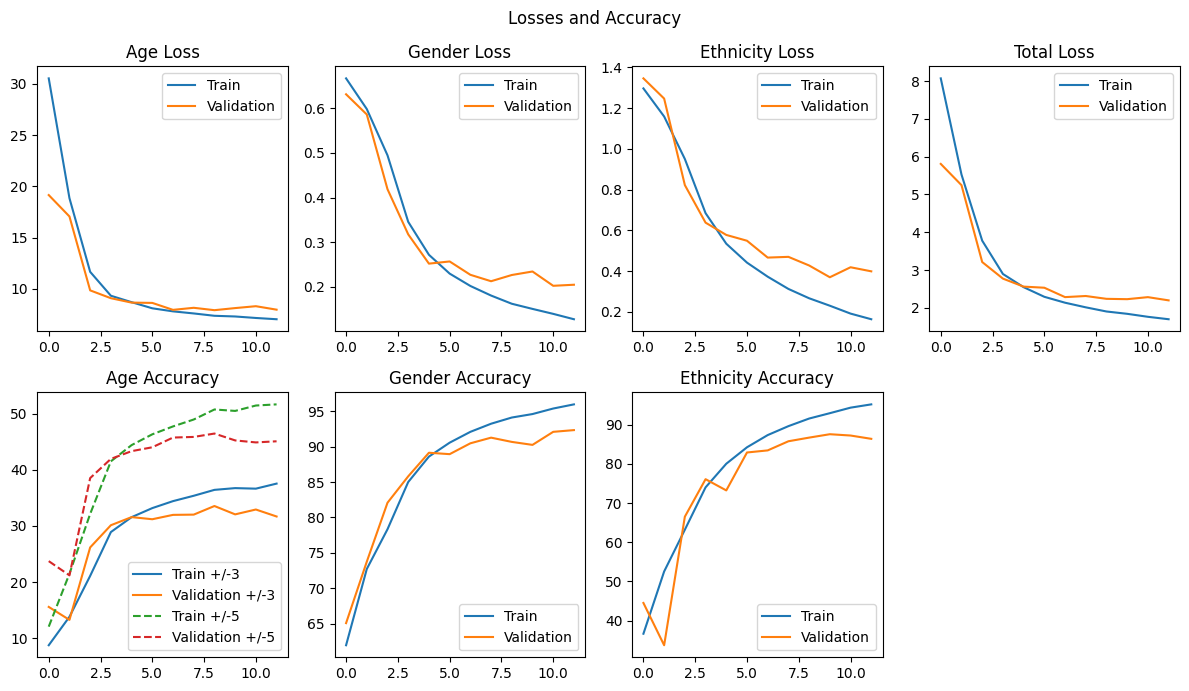

In [24]:
plotLossesAccuracy(losses, accuracy)

In [25]:
#model = torch.load(modelPath)
#model.eval()

In [26]:
#for name, param in resnetModel.named_parameters():
#    print(name, param.requires_grad)

In [27]:
def testNetwork(model, testLoader, device):
    model.eval()
    correctAge3, correctAge5, correctGender, correctEthnicity = 0, 0, 0, 0
    correctTest = 0
    totalTest = 0

    allAgePredictions = torch.tensor([], dtype=torch.float32).to(device)
    allGenderPredictions = torch.tensor([], dtype=torch.long).to(device)
    allEthnicityPredictions = torch.tensor([], dtype=torch.long).to(device)
    allAgeLabels = torch.tensor([], dtype=torch.float32).to(device)
    allGenderLabels = torch.tensor([], dtype=torch.long).to(device)
    allEthnicityLabels = torch.tensor([], dtype=torch.long).to(device)

    ### TESTING ###
    with torch.no_grad(): 
        for batch_nr, (images, labels) in enumerate(testLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            ethnicityLabels = labels[:, 2]
            
            # Get predictions and get the amount of correct predicitons
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            agePredictions = torch.round(agePredictions).view(1, -1)
            correctAge3 += ((agePredictions - ageLabels).abs() <= 3).sum().item()
            correctAge5 += ((agePredictions - ageLabels).abs() <= 5).sum().item()

            _, genderPredictions = torch.max(genderPredictions, 1) 
            correctGender += (genderPredictions == genderLabels).sum().item() 

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            correctEthnicity += (ethnicityPredictions == ethnicityLabels).sum().item() 

            totalTest += len(images)
            
            # concatenate the predictions and labels of each batch
            allAgePredictions = torch.cat((allAgePredictions, agePredictions), dim=1)
            allGenderPredictions = torch.cat((allGenderPredictions, genderPredictions), dim=0)
            allEthnicityPredictions = torch.cat((allEthnicityPredictions, ethnicityPredictions), dim=0)
            allAgeLabels = torch.cat((allAgeLabels, ageLabels), dim=0)
            allGenderLabels = torch.cat((allGenderLabels, genderLabels), dim=0)
            allEthnicityLabels = torch.cat((allEthnicityLabels, ethnicityLabels), dim=0)

    age3Accuracy = 100 * correctAge3 / totalTest
    age5Accuracy = 100 * correctAge5 / totalTest
    genderAccuracy = 100 * correctGender / totalTest
    ethnicityAccuracy = 100 * correctEthnicity / totalTest

    print(f"Test Accuracy: (Age +/-3 years: {age3Accuracy:.2f}%, Age +/-5 years: {age5Accuracy:.2f}%, Gender: {genderAccuracy:.2f}%, Ethnicity: {ethnicityAccuracy:.2f}%)")
    return allAgePredictions, allGenderPredictions, allEthnicityPredictions, allAgeLabels, allGenderLabels, allEthnicityLabels

In [28]:
agePredictions, genderPredictions, ethnicityPredictions, ageLabels, genderLabels, ethnicityLabels = testNetwork(resnetModel, validLoader, device)

Test Accuracy: (Age +/-3 years: 39.46%, Age +/-5 years: 55.63%, Gender: 92.55%, Ethnicity: 87.90%)


In [29]:
agePredictions, ageLabels

(tensor([[22., 32., 53.,  ..., 21., 45., 25.]], device='cuda:0'),
 tensor([ 1., 20., 58.,  ..., 18., 42., 26.], device='cuda:0'))

In [30]:
ethnicityPredictions, ethnicityLabels

(tensor([1, 3, 1,  ..., 2, 3, 0], device='cuda:0'),
 tensor([3., 0., 1.,  ..., 0., 3., 0.], device='cuda:0'))

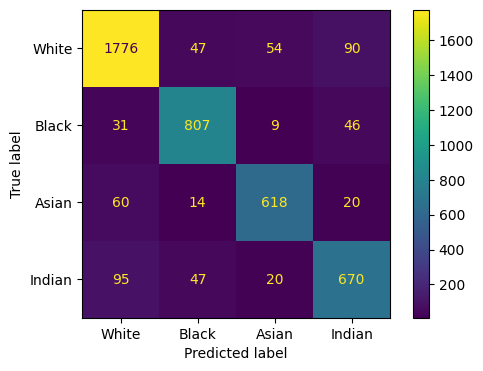

In [31]:

GENDER = ['M', 'F']
#ETHNICITY = ['White', 'Black', 'Asian', 'Indian', 'Others']
ETHNICITY = ['White', 'Black', 'Asian', 'Indian']
import pandas as pd
import sklearn.metrics as skmetric

matrix = skmetric.confusion_matrix(ethnicityLabels.cpu(), ethnicityPredictions.cpu())
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ETHNICITY)
fig, ax = plt.subplots(figsize=(6,4))
display.plot(ax=ax)
plt.show()

#print(skmetric.classification_report(arrayEmotionNumToString(testEncodedEmotionLabel), arrayEmotionNumToString(predTestEncodedEmotionLabel)))

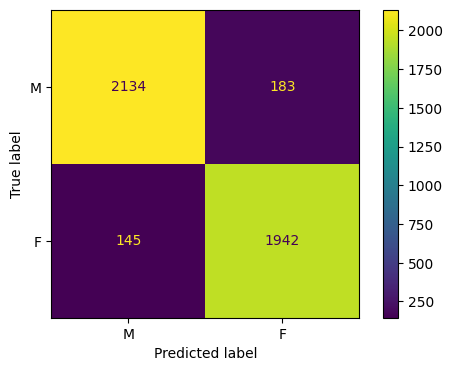

In [32]:
matrix = skmetric.confusion_matrix(genderLabels.cpu(), genderPredictions.cpu())
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=GENDER)
fig, ax = plt.subplots(figsize=(6,4))
display.plot(ax=ax)
plt.show()

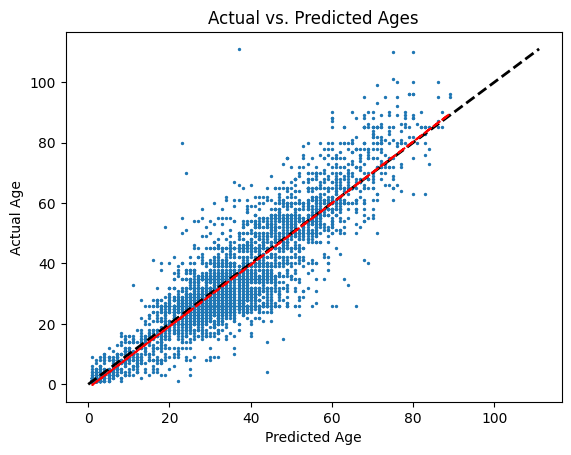

In [37]:
x, y = agePredictions.cpu()[0], ageLabels.cpu()
plt.scatter(x, y, s=2)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2)

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, 'r--')

plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.title('Actual vs. Predicted Ages')
plt.show()

In [34]:
max(ageLabels.cpu()), min(ageLabels.cpu())

(tensor(111.), tensor(1.))